In [203]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold
from imblearn.over_sampling import SMOTE

gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpus, True)
    print("GPU 환경에서 실행됩니다.")
else:
    print("GPU가 감지되지않습니다. CPU환경에서 실행됩니다.")

GPU가 감지되지않습니다. CPU환경에서 실행됩니다.


In [204]:
import os
file_path = os.getcwd()
train_path = os.path.join(file_path, "데이터셋", "train.csv")
test_path = os.path.join(file_path, "데이터셋", "test.csv")
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)


In [205]:
def preprocess(df):
    df = df.copy()
    def year(x):
        return "".join(v.replace("이상", "").replace("년", "") for v in x.split(" "))

    def year1(x):
        return "".join(v.replace('1미만', "0") for v in x.split(" "))

 
    df["현재 직장 근속 연수"] = df["현재 직장 근속 연수"].apply(year)
    df["현재 직장 근속 연수"] = df["현재 직장 근속 연수"].apply(year1).astype(int)
    df["현재 대출 잔액"] = df["현재 대출 잔액"].where((df["현재 대출 잔액"] > 0), np.nan)
    df["현재 대출 잔액"] = df["현재 대출 잔액"].fillna(df["현재 대출 잔액"].median())
    df["최대 신용한도"] = df["최대 신용한도"].where((df["최대 신용한도"] > 0), np.nan)
    df["최대 신용한도"] = df["최대 신용한도"].fillna(df["최대 신용한도"].median())
    df["대출액+신용액"] = df["현재 대출 잔액"] + df["현재 미상환 신용액"]
    df["상환액 분위"] = pd.qcut(df["대출액+신용액"], 5, labels = [1,2,3,4,5], duplicates = "drop").astype(int)

    df["신용거래분위"] = pd.qcut(df["신용 거래 연수"], 5, labels = [1,2,3,4,5], duplicates = "drop").astype(int)
    df["신용점수분위"] = pd.qcut(df["신용 점수"], 5, labels = [1,2,3,4,5], duplicates= "drop").astype(int)

    df["연간소득분위"] = pd.qcut(df["연간 소득"], 5, labels = [1,2,3,4,5], duplicates = "drop").astype(int)
    df["개설된_신용계좌_분위수"] = pd.qcut(df["개설된 신용계좌 수"], 5, labels = [1,2,3,4,5], duplicates = "drop").astype(int)
    df["대출잔액 분위수"] = pd.qcut(df["현재 대출 잔액"], 5, labels = [1,2,3,4,5], duplicates= "drop").astype(int)
    df["직장근속연수 분위수"] = pd.qcut(df["현재 직장 근속 연수"], 7, labels = [1,2,3,4,5], duplicates= "drop").astype(int)
    

    df["신용한도vs대출잔액"] = (df["현재 대출 잔액"] + df["현재 미상환 신용액"] )  / ((df["최대 신용한도"] * df["개설된 신용계좌 수"] ) )* 100

    df["DTI"] = ((df["현재 대출 잔액"] + df["현재 미상환 신용액"]) / df["연간 소득"]) * 100
    df["DTR"] = ((df["월 상환 부채액"] + 1) / (df["연간 소득"] / 12)) * 100
    #df["DBI"] = (df["DTI"] + df["DTR"]) / 2
    #df["DRS"] = (df["DTI"] * df["DTR"])

    df["위험분자1"] = ((df["개설된_신용계좌_분위수"] > 3) & (df["연간소득분위"] < 3)).astype(int)
    df["위험분자2"] = (((df["신용 문제 발생 횟수"] > 0) & (df["개인 파산 횟수"] > 0)) | (df["체납 세금 압류 횟수"] > 0)).astype(int)
    df["위험분자3"] = ((df["개설된_신용계좌_분위수"] > 3) & (df["상환액 분위"] > 3)).astype(int)
    df["위험분자4"] = ((df["신용점수분위"] <= 3) & (df["개설된_신용계좌_분위수"] > 3)).astype(int)
    df["위험분자5"] = ((df["직장근속연수 분위수"] < 3) & (df["신용점수분위"] < 3)).astype(int)

    df["위험분자"] = df["위험분자1"] + df["위험분자2"] + df["위험분자3"] + df["위험분자4"] + df["위험분자5"]


    df["근속연수vs거래연수"] = (df["현재 직장 근속 연수"] / df["신용 거래 연수"]) * 100


    df["위험도 점수"] = df["신용점수분위"] - df["상환액 분위"]
    #df["문제 발생 점수"] = df["신용 문제 발생 횟수"] + df["개인 파산 횟수"] + df["체납 세금 압류 횟수"]


    df["VIP"] = ((df["개설된_신용계좌_분위수"] > 3) & (df["신용점수분위"] > 3)).astype(int)

    df["개설계좌vs연체이후개월수"] = df["개설된 신용계좌 수"] / (df["마지막 연체 이후 경과 개월 수"] + 1)
    


    
    df["신용 거래 연수"] = df["신용 거래 연수"].astype(int)
    신용거래 = df.groupby("개설된 신용계좌 수")["신용 거래 연수"].agg("mean")
    #df["신용거래연수_개설신용계좌"] = df["개설된 신용계좌 수"].map(신용거래)
    신용대출 = df.groupby("개설된 신용계좌 수")["현재 대출 잔액"].agg("mean")
    #df["신용계좌vs대출잔액"] = df["개설된 신용계좌 수"].map(신용대출)
    #df["신용계좌vs대출잔액"] = df["신용계좌vs대출잔액"] / 10000
    
    cols = (["주거 형태","대출 목적", "대출 상환 기간"])
    for c in cols:
        lb = LabelEncoder()
        lb.fit(df[c].values)
        df[c] = lb.transform(list(df[c].values))
        df[c] = df[c].astype(int)
        
    bankcount_purpose = df.groupby("대출 목적")["개설된 신용계좌 수"].agg("median")
    purpose_bankcount = df.groupby("개설된 신용계좌 수")["연간 소득"].agg("median")
    #df["계좌수별_소득"] = df["개설된 신용계좌 수"].map(purpose_bankcount)
    #df["계좌수별_소득"] = df["계좌수별_소득"].astype(int)  

    df = df.drop(["대출액+신용액", "상환액 분위"], axis = 1)
    
    return df

train = preprocess(train_df)
test = preprocess(test_df)
train.head()

,UID,주거 형태,연간 소득,현재 직장 근속 연수,체납 세금 압류 횟수,개설된 신용계좌 수,신용 거래 연수,최대 신용한도,신용 문제 발생 횟수,마지막 연체 이후 경과 개월 수,...,위험분자1,위험분자2,위험분자3,위험분자4,위험분자5,위험분자,근속연수vs거래연수,위험도 점수,VIP,개설계좌vs연체이후개월수
0,TRAIN_00000,1,1941337.5,10,0.0,9,13,400597.5,0,24,...,0,0,0,0,0,0,74.626866,1,0,0.360000
1,TRAIN_00001,0,1979505.0,10,0.0,5,15,360679.5,0,11,...,0,0,0,0,0,0,66.225166,-1,0,0.416667
2,TRAIN_00002,0,1356381.0,4,0.0,12,18,491770.5,1,74,...,0,1,0,0,0,1,21.276596,2,0,0.160000
3,TRAIN_00003,0,1049017.5,6,0.0,15,14,411546.0,1,22,...,1,1,0,0,0,2,40.540541,2,1,0.652174
4,TRAIN_00004,0,4320217.5,2,0.0,11,26,895288.5,0,32,...,0,0,0,0,0,0,7.662835,-2,0,0.333333


C:\Users\yunju\AppData\Local\Temp\ipykernel_85964\235274021.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train["신용 점수"], color = "b", bins = 100, hist_kws = {"alpha": 0.3})


<Axes: xlabel='신용 점수', ylabel='Density'>

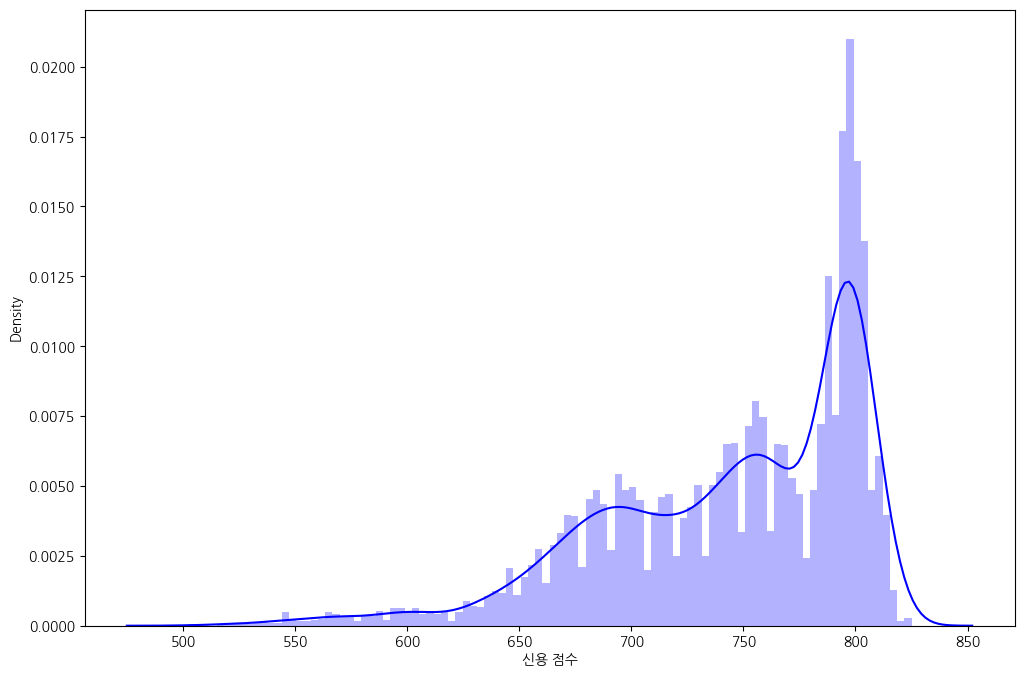

In [206]:
plt.rc("font", family = "NanumGothic")
plt.figure(figsize = (12,8))
sns.distplot(train["신용 점수"], color = "b", bins = 100, hist_kws = {"alpha": 0.3})

In [207]:
target = train["채무 불이행 여부"]
uid = test["UID"]

train = train.drop(["채무 불이행 여부", "UID"], axis = 1)
test = test.drop("UID", axis = 1)

In [208]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   주거 형태              10000 non-null  int64  
 1   연간 소득              10000 non-null  float64
 2   현재 직장 근속 연수        10000 non-null  int64  
 3   체납 세금 압류 횟수        10000 non-null  float64
 4   개설된 신용계좌 수         10000 non-null  int64  
 5   신용 거래 연수           10000 non-null  int64  
 6   최대 신용한도            10000 non-null  float64
 7   신용 문제 발생 횟수        10000 non-null  int64  
 8   마지막 연체 이후 경과 개월 수  10000 non-null  int64  
 9   개인 파산 횟수           10000 non-null  int64  
 10  대출 목적              10000 non-null  int64  
 11  대출 상환 기간           10000 non-null  int64  
 12  현재 대출 잔액           10000 non-null  float64
 13  현재 미상환 신용액         10000 non-null  float64
 14  월 상환 부채액           10000 non-null  float64
 15  신용 점수              10000 non-null  int64  
 16  신용거래분위             1000

In [209]:
from scipy.stats import boxcox
from scipy.special import boxcox1p

cols = ["최대 신용한도", "연간 소득", "월 상환 부채액", "현재 대출 잔액", "현재 미상환 신용액", "근속연수vs거래연수", "신용한도vs대출잔액", "신용 점수", "DTI", "DTR", "개설된 신용계좌 수", "마지막 연체 이후 경과 개월 수"]
for c in cols:
    train[c] = train[c].where((train[c] > 0), np.nan)
    test[c] = test[c].where((test[c] > 0), np.nan)
    train[c] = train[c].fillna(train[c].median())
    test[c] = test[c].fillna(test[c].median())
    
    train[c], l = boxcox(train[c])
    test[c]= boxcox(test[c], lmbda = l)
print(train[cols].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   최대 신용한도            10000 non-null  float64
 1   연간 소득              10000 non-null  float64
 2   월 상환 부채액           10000 non-null  float64
 3   현재 대출 잔액           10000 non-null  float64
 4   현재 미상환 신용액         10000 non-null  float64
 5   근속연수vs거래연수         10000 non-null  float64
 6   신용한도vs대출잔액         10000 non-null  float64
 7   신용 점수              10000 non-null  float64
 8   DTI                10000 non-null  float64
 9   DTR                10000 non-null  float64
 10  개설된 신용계좌 수         10000 non-null  float64
 11  마지막 연체 이후 경과 개월 수  10000 non-null  float64
dtypes: float64(12)
memory usage: 937.6 KB
None


C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  func(*args, **kwargs)
C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


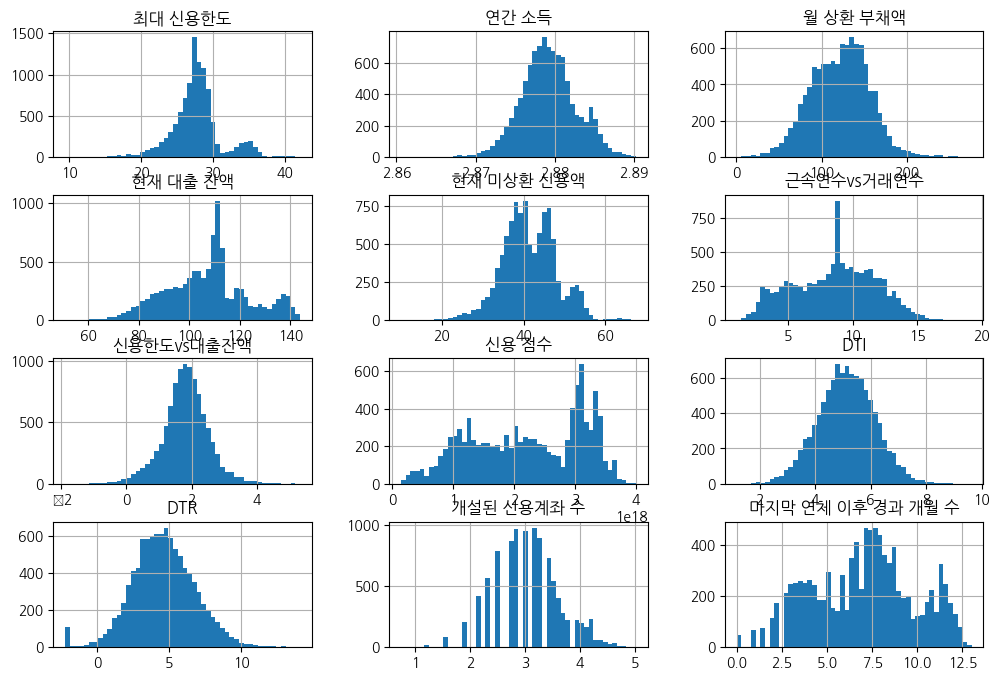

In [210]:
import matplotlib.font_manager as fm

plt.rc("font", family = "NanumGothic")

train[cols].hist(figsize = (12,8), bins = 50);

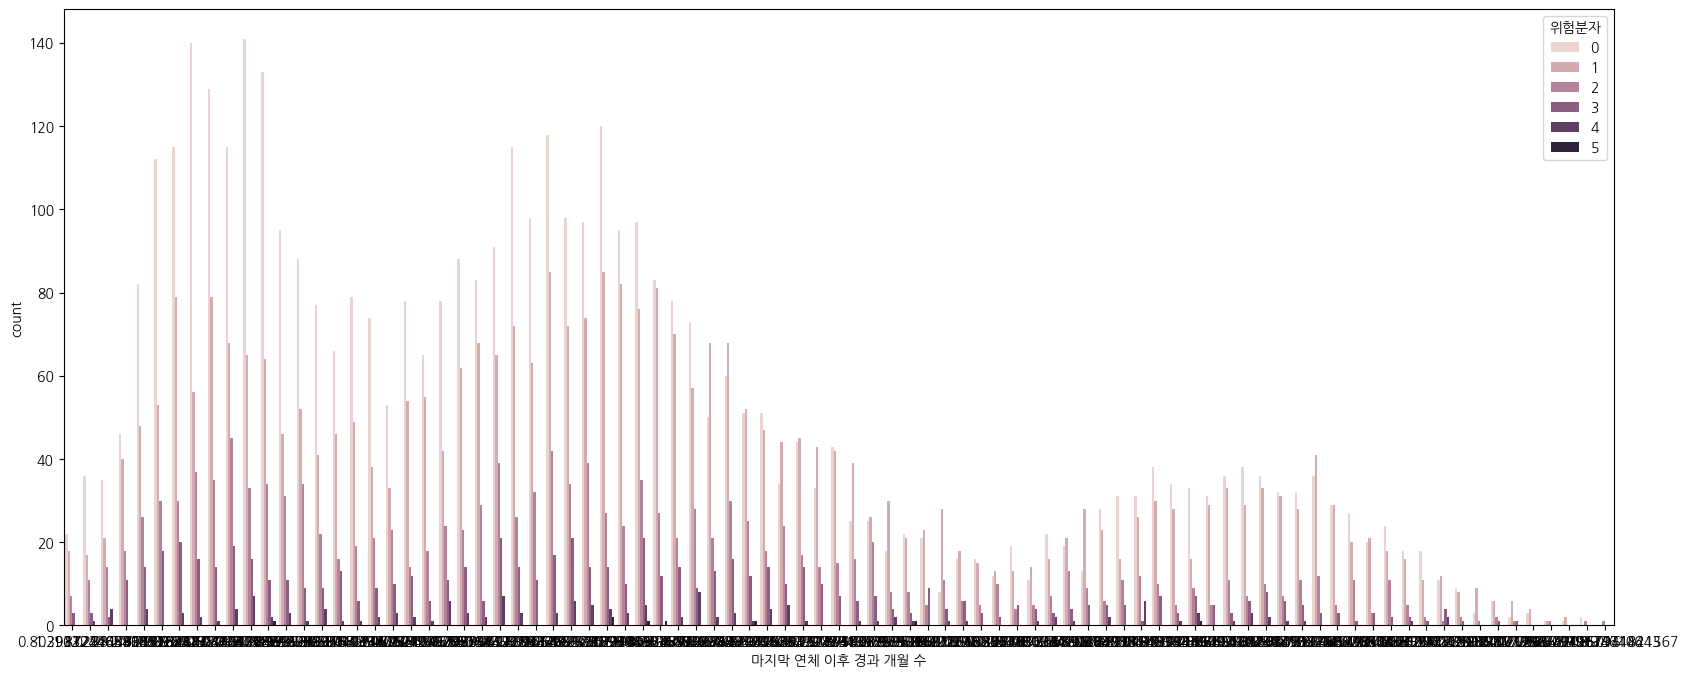

In [211]:
from matplotlib.ticker import FuncFormatter
plt.figure(figsize = (20,8))
sns.countplot(x = "마지막 연체 이후 경과 개월 수", hue = "위험분자", data = train)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:0001.0f}'))
plt.show()

C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  func(*args, **kwargs)
C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


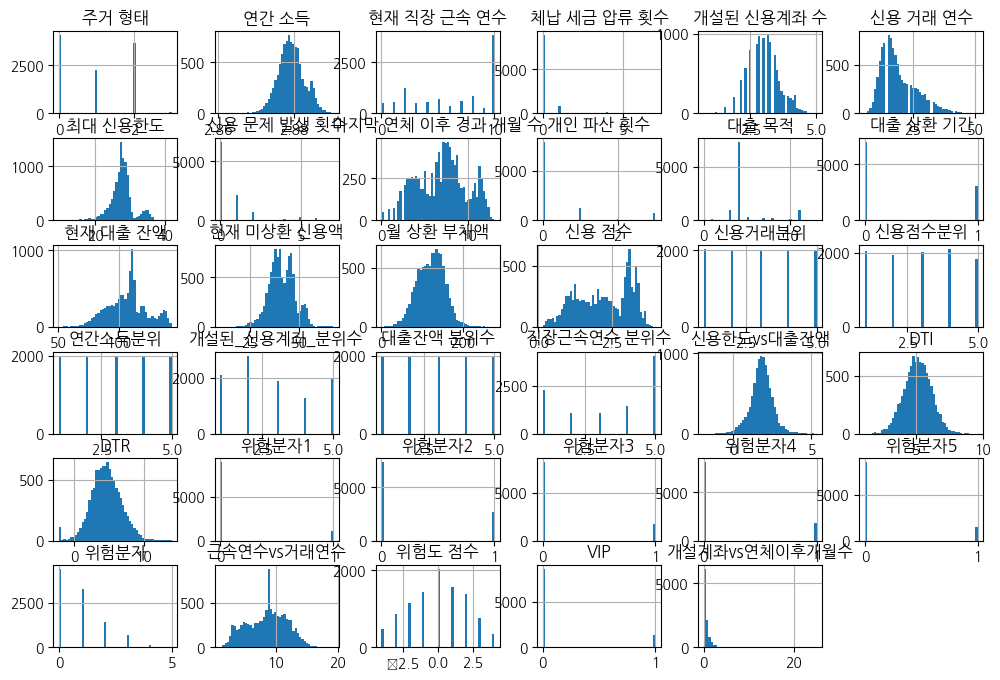

In [212]:
train.hist(figsize = (12,8),bins = 50);

C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()


<Axes: >

C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  func(*args, **kwargs)
C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


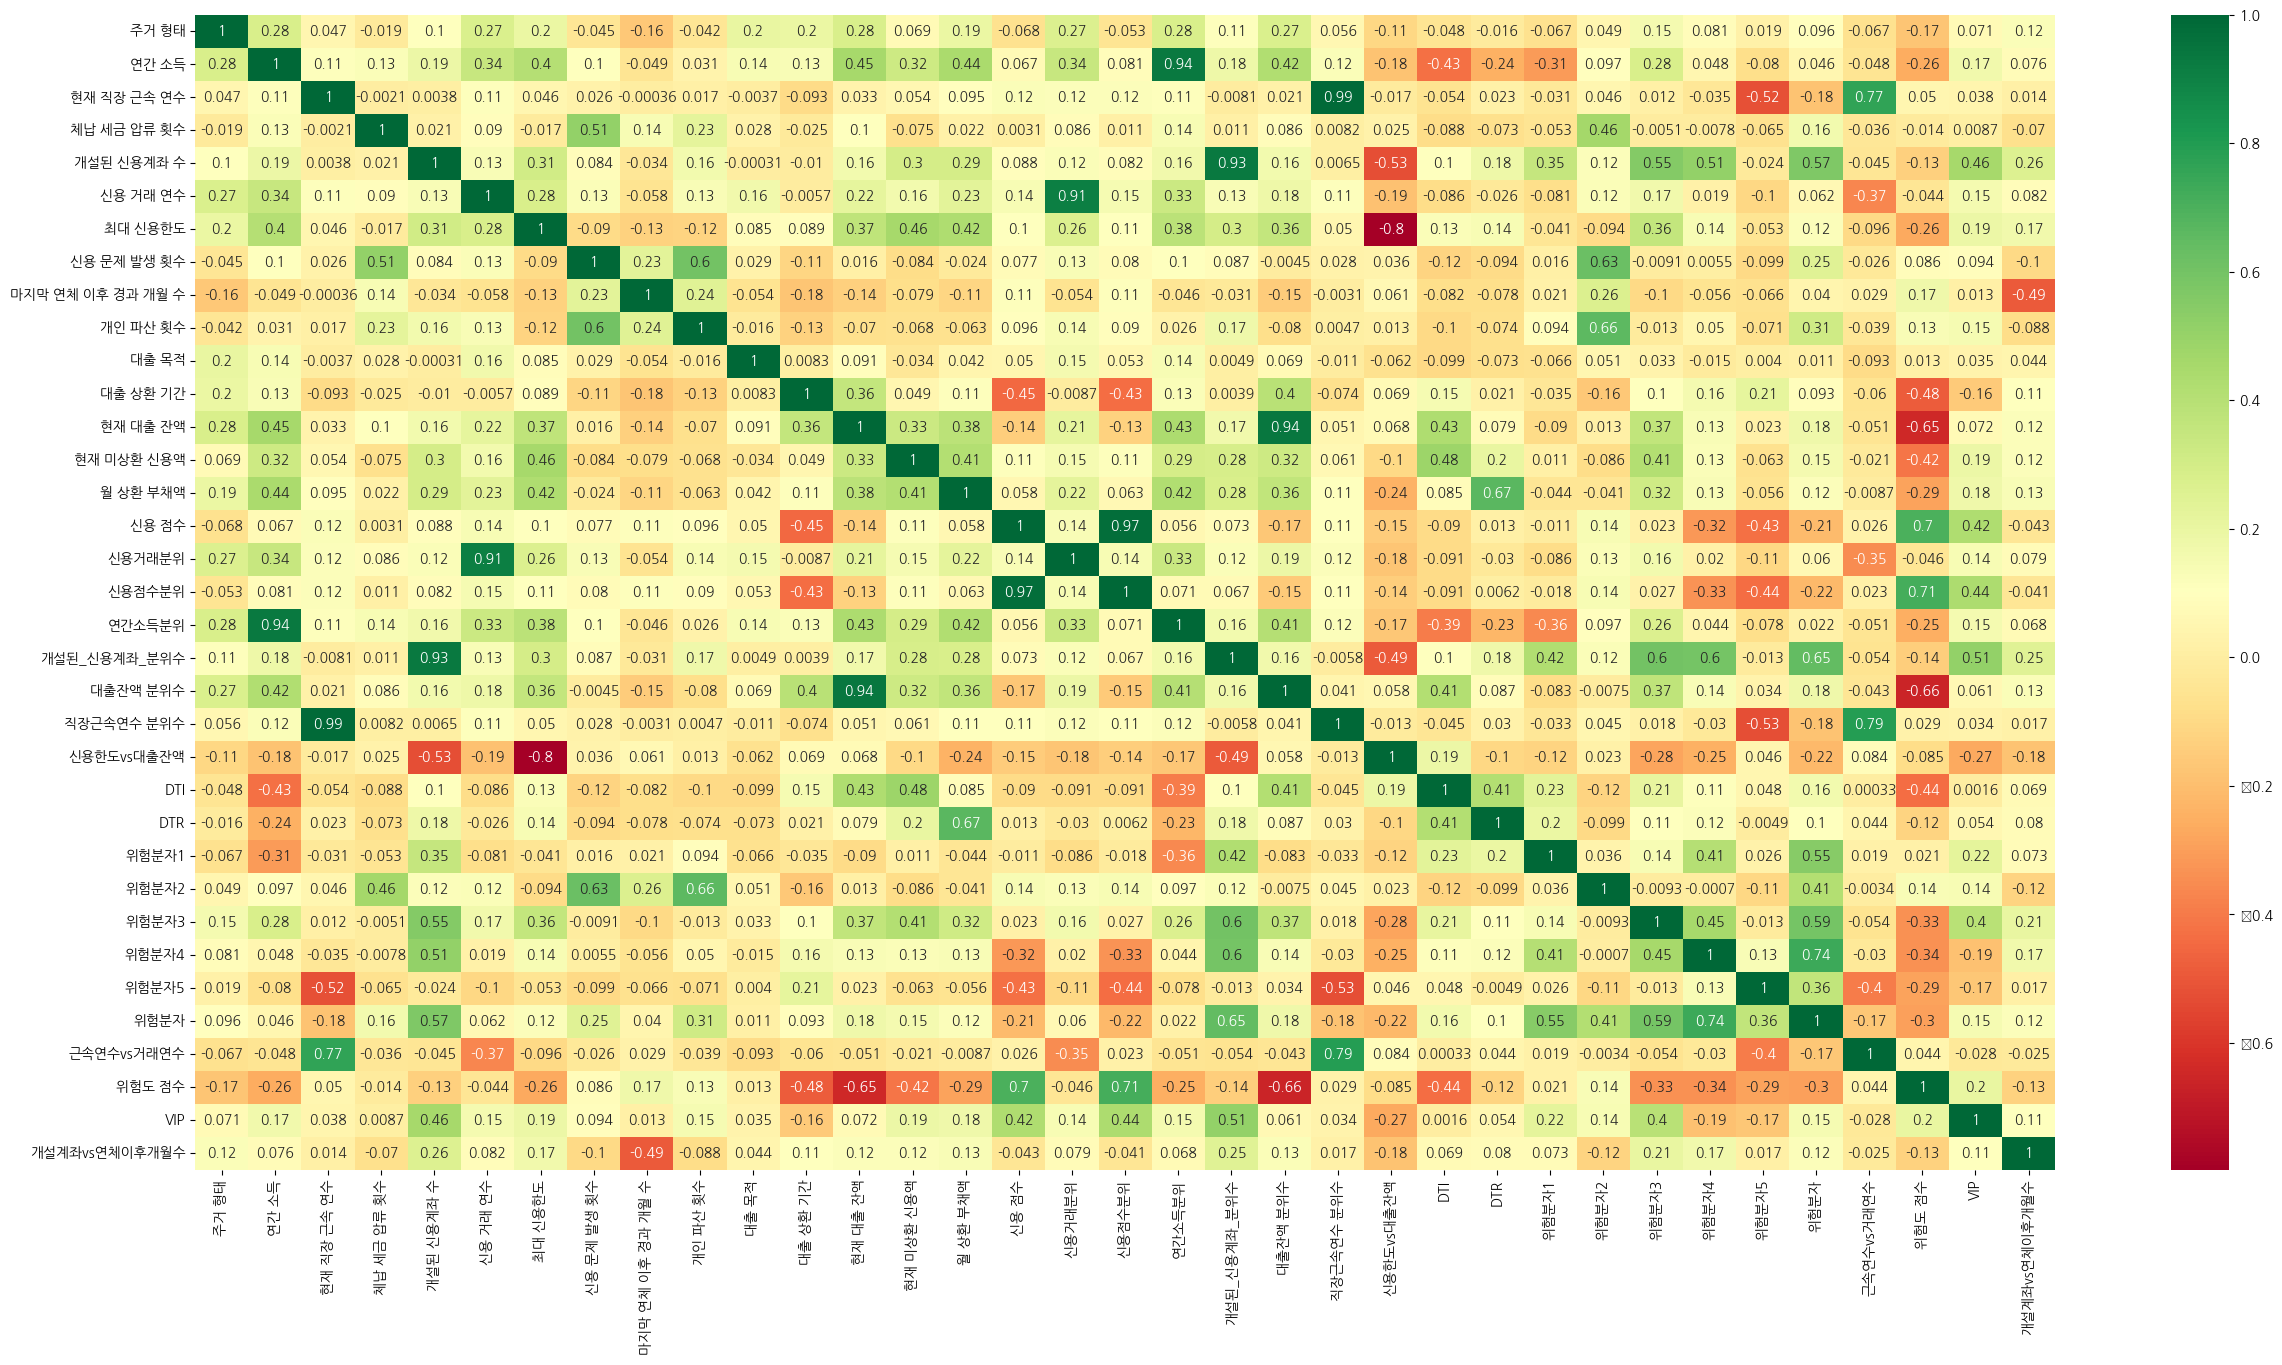

In [213]:
corrmat = train.corr()
corr_cols = corrmat.index[abs(corrmat["위험분자"] >= 0.1)]
plt.figure(figsize = (30,15))
sns.heatmap(train.corr(), annot = True, cmap = "RdYlGn")

In [214]:
for c in cols:
    train[c] = train[c].where((train[c] > 0), np.nan)
    test[c] = test[c].where((test[c] > 0), np.nan)
    train[c] = train[c].fillna(train[c].median())
    test[c] = test[c].fillna(test[c].median())

In [215]:
train[cols].describe()

,최대 신용한도,연간 소득,월 상환 부채액,현재 대출 잔액,현재 미상환 신용액,근속연수vs거래연수,신용한도vs대출잔액,신용 점수,DTI,DTR,개설된 신용계좌 수,마지막 연체 이후 경과 개월 수
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,27.687612,2.879252,121.469908,106.947209,41.396724,8.606249,1.840611,2.213053e+18,5.124920,4.729653,3.091183,7.075440
std,3.441236,0.003492,34.254658,16.404588,6.755067,3.180678,0.674666,9.150231e+17,1.033056,2.023482,0.589468,2.760305
min,9.454365,2.860570,0.439571,50.907395,10.036393,1.031145,0.003458,1.460260e+17,1.172243,0.028024,0.739144,0.802931
25%,26.055129,2.877004,96.981417,95.956774,36.999796,6.162542,1.446207,1.388818e+18,4.442472,3.300550,2.706044,4.789652
50%,27.682038,2.879109,123.272652,108.435283,40.928808,8.826581,1.835205,2.232445e+18,5.130484,4.602187,3.148094,7.185961
75%,29.031378,2.881363,145.131711,115.023128,45.863310,11.007160,2.230454,3.068984e+18,5.820123,6.010768,3.507406,8.829175
max,42.084575,2.890255,275.743292,143.795523,67.417392,19.217185,5.330435,3.994169e+18,9.639172,14.056910,5.013910,13.014168


In [216]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   주거 형태              10000 non-null  int64  
 1   연간 소득              10000 non-null  float64
 2   현재 직장 근속 연수        10000 non-null  int64  
 3   체납 세금 압류 횟수        10000 non-null  float64
 4   개설된 신용계좌 수         10000 non-null  float64
 5   신용 거래 연수           10000 non-null  int64  
 6   최대 신용한도            10000 non-null  float64
 7   신용 문제 발생 횟수        10000 non-null  int64  
 8   마지막 연체 이후 경과 개월 수  10000 non-null  float64
 9   개인 파산 횟수           10000 non-null  int64  
 10  대출 목적              10000 non-null  int64  
 11  대출 상환 기간           10000 non-null  int64  
 12  현재 대출 잔액           10000 non-null  float64
 13  현재 미상환 신용액         10000 non-null  float64
 14  월 상환 부채액           10000 non-null  float64
 15  신용 점수              10000 non-null  float64
 16  신용거래분위             1000

In [217]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()
X_scaled = minmax.fit_transform(train)
test_scaled = minmax.transform(test)
"""
standard = StandardScaler()
X_scaled = standard.fit_transform(train)
test_scaled = standard.transform(test)
"""

'\nstandard = StandardScaler()\nX_scaled = standard.fit_transform(train)\ntest_scaled = standard.transform(test)\n'

In [218]:
smote = SMOTE(random_state= 42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, target)

Fold 1 시작!
Epoch 1/100


C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4866 - loss: 0.6971 - val_accuracy: 0.5436 - val_loss: 0.6894
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5127 - loss: 0.6929 - val_accuracy: 0.5763 - val_loss: 0.6857
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5296 - loss: 0.6899 - val_accuracy: 0.5960 - val_loss: 0.6823
Epoch 4/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5469 - loss: 0.6873 - val_accuracy: 0.6089 - val_loss: 0.6790
Epoch 5/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5701 - loss: 0.6839 - val_accuracy: 0.6115 - val_loss: 0.6754
Epoch 6/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5923 - loss: 0.6801 - val_accuracy: 0.6271 - val_loss: 0.6719
Epoch 7/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5928 - loss: 0.6786 - val_accuracy: 0.6290 - val_loss: 0.6683
Epoch 8/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5959 - loss: 0.6758 - val_accuracy: 0.6351

C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5186 - loss: 0.6960 - val_accuracy: 0.5135 - val_loss: 0.6885
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5199 - loss: 0.6921 - val_accuracy: 0.5704 - val_loss: 0.6833
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5420 - loss: 0.6876 - val_accuracy: 0.6053 - val_loss: 0.6789
Epoch 4/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5535 - loss: 0.6844 - val_accuracy: 0.6292 - val_loss: 0.6746
Epoch 5/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5696 - loss: 0.6810 - val_accuracy: 0.6247 - val_loss: 0.6705
Epoch 6/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5831 - loss: 0.6765 - val_accuracy: 0.6296 - val_loss: 0.6665
Epoch 7/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6071 - loss: 0.6710 - val_accuracy: 0.6372 - val_loss: 0.6628
Epoch 8/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5985 - loss: 0.6692 - val_accuracy: 0.6402

C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.4839 - loss: 0.7029 - val_accuracy: 0.5135 - val_loss: 0.6926
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5059 - loss: 0.6971 - val_accuracy: 0.5510 - val_loss: 0.6880
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5204 - loss: 0.6914 - val_accuracy: 0.5685 - val_loss: 0.6839
Epoch 4/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5417 - loss: 0.6880 - val_accuracy: 0.5867 - val_loss: 0.6798
Epoch 5/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5615 - loss: 0.6821 - val_accuracy: 0.5992 - val_loss: 0.6759
Epoch 6/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5641 - loss: 0.6801 - val_accuracy: 0.6046 - val_loss: 0.6721
Epoch 7/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5902 - loss: 0.6740 - val_accuracy: 0.6167 - val_loss: 0.6682
Epoch 8/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5909 - loss: 0.6723 - val_accu

C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5163 - loss: 0.6907 - val_accuracy: 0.5977 - val_loss: 0.6850
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5458 - loss: 0.6875 - val_accuracy: 0.6095 - val_loss: 0.6807
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5563 - loss: 0.6846 - val_accuracy: 0.6201 - val_loss: 0.6769
Epoch 4/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5823 - loss: 0.6809 - val_accuracy: 0.6182 - val_loss: 0.6732
Epoch 5/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5882 - loss: 0.6776 - val_accuracy: 0.6250 - val_loss: 0.6695
Epoch 6/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5806 - loss: 0.6758 - val_accuracy: 0.6311 - val_loss: 0.6661
Epoch 7/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5930 - loss: 0.6729 - val_accuracy: 0.6326 - val_loss: 0.6627
Epoch 8/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6112 - loss: 0.6678 - val_accuracy: 0.6326

C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5350 - loss: 0.6902 - val_accuracy: 0.5757 - val_loss: 0.6852
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5413 - loss: 0.6875 - val_accuracy: 0.5909 - val_loss: 0.6818
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5503 - loss: 0.6871 - val_accuracy: 0.6072 - val_loss: 0.6787
Epoch 4/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5680 - loss: 0.6819 - val_accuracy: 0.6156 - val_loss: 0.6751
Epoch 5/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5802 - loss: 0.6791 - val_accuracy: 0.6277 - val_loss: 0.6715
Epoch 6/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5862 - loss: 0.6762 - val_accuracy: 0.6376 - val_loss: 0.6677
Epoch 7/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5930 - loss: 0.6739 - val_accuracy: 0.6444 - val_loss: 0.6640
Epoch 8/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6176 - loss: 0.6678 - val_accuracy: 0.6474

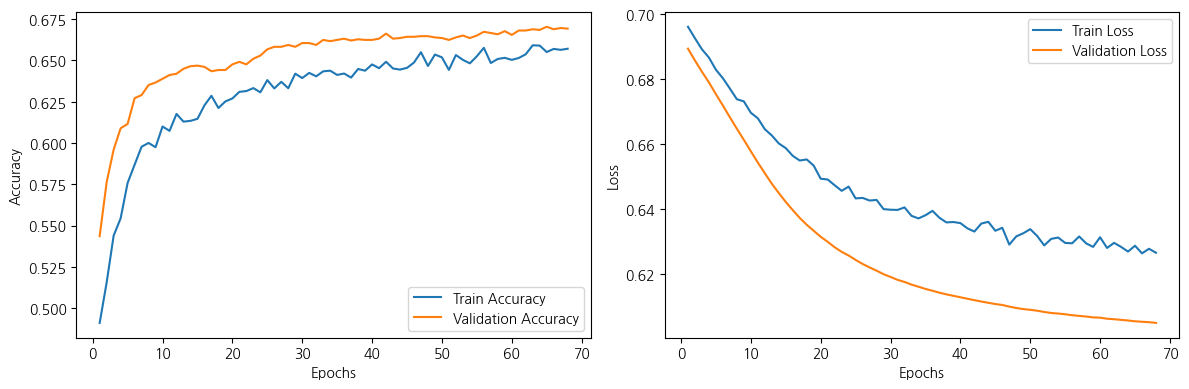

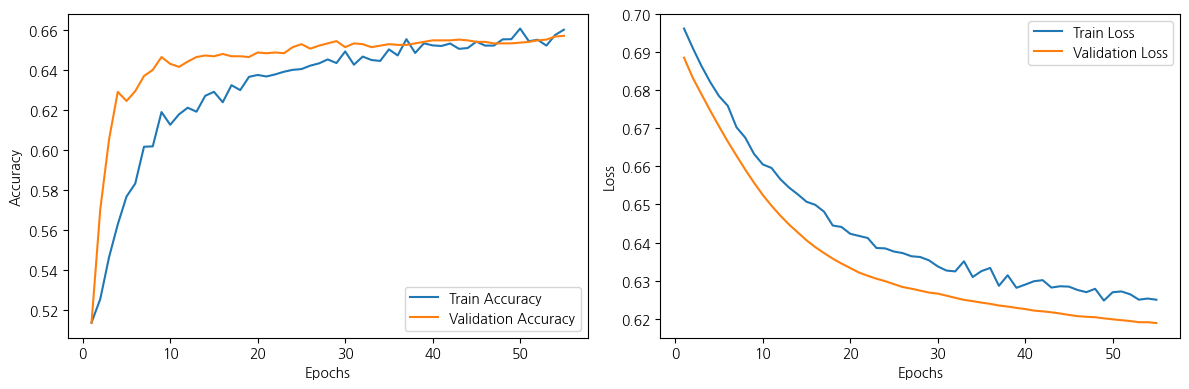

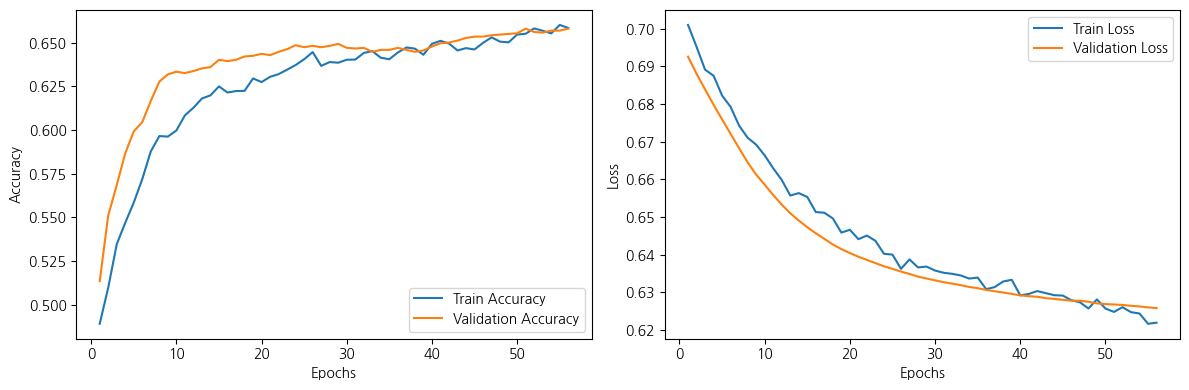

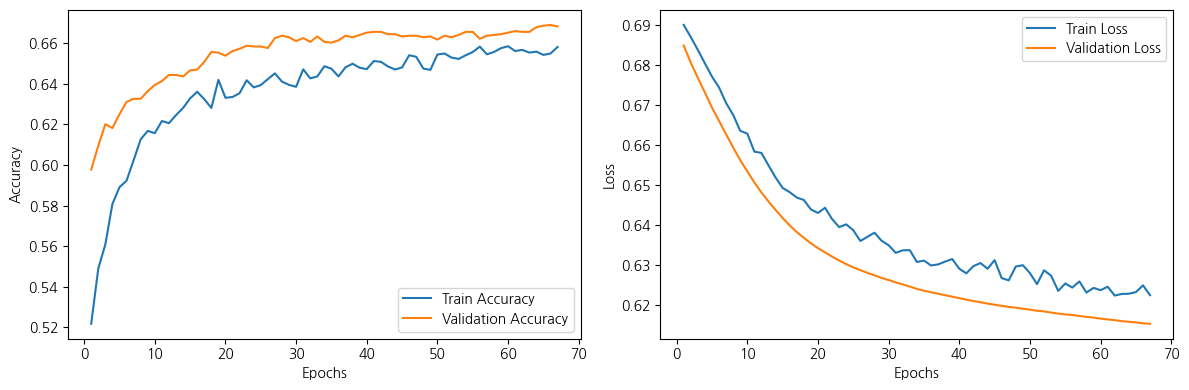

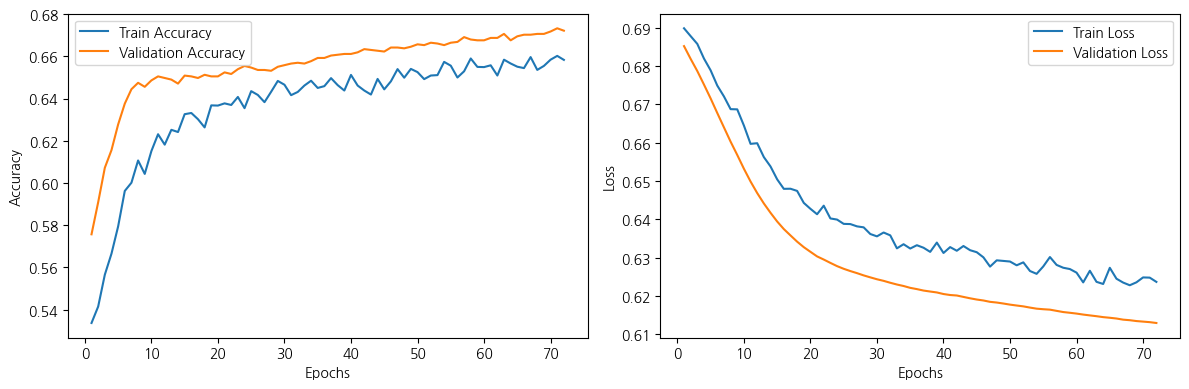

In [219]:
all_history = []
kf = KFold(n_splits = 5, shuffle= True, random_state= 42)
fold = 1
roc_auc_scores = []

for train_index, valid_index in kf.split(X_resampled):
    print(f"Fold {fold} 시작!")
    
    X_train_fold, X_valid_fold = X_resampled[train_index], X_resampled[valid_index]
    y_train_fold, y_valid_fold = y_resampled[train_index], y_resampled[valid_index]

    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation= "relu", input_shape = (X_train_fold.shape[1],)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(64, activation = "relu"),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(32, activation= "relu"),
        tf.keras.layers.Dense(1, activation= "sigmoid")
    ])

    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-5),
        loss = "binary_crossentropy",
        metrics = ["accuracy"]
    )

    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        patience = 5,
        min_delta = 0.001,
        restore_best_weights = True
    )

    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data = (X_valid_fold, y_valid_fold),
        epochs = 100,
        callbacks = earlystop,
        verbose = 1
    )
    all_history.append(history.history)
    y_valid_pred = model.predict(X_valid_fold).ravel()
    roc_auc = roc_auc_score(y_valid_fold, y_valid_pred)
    print(f"Fold{fold} ROC-AUC score {roc_auc:.4f}")
    roc_auc_scores.append(roc_auc)
    fold += 1

print(f"교차 검증 ROC-AUC 평균점수 {np.mean(roc_auc_scores):.4f}")

for i, history in enumerate(all_history):
    epochs = range(1, len(history["loss"]) + 1)
    plt.figure(figsize = (12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["accuracy"], label = "Train Accuracy")
    plt.plot(epochs, history["val_accuracy"], label = "Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, history["loss"], label = "Train Loss")
    plt.plot(epochs, history["val_loss"], label = "Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [220]:
pred = model.predict(test_scaled).ravel()


submission = pd.DataFrame({"UID": uid, "채무 불이행 확률": pred * 100 })
submission.to_csv("C:/Users/yunju/OneDrive/바탕 화면/submissions/채무불이행 예측/submission8.csv", index = False)
submission.head()

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,UID,채무 불이행 확률
0,TEST_0000,79.407028
1,TEST_0001,45.681366
2,TEST_0002,37.734665
3,TEST_0003,25.238785
4,TEST_0004,39.896023
